In this tutorial, we will show you how to use Haystack to evaluate the performance of a RAG pipeline.

We will use the dataset from the [ARAGOG - Advanced Retrieval Augmented Generation Output Grading (ARAGOG)](https://arxiv.org/pdf/2404.01037) paper.
The dataset is composed of a collection of 13 public AI/LLM-ArXiv research papers and 107 question-answer (QA) pairs. The (QA) pairs generated with the assistance of GPT-4, and then each pair was validated/corrected by humans.

We will use the following Haystack components to evaluate the performance of a RAG pipeline:

- [ContextRelevance](https://docs.haystack.deepset.ai/docs/contextrelevanceevaluator)
- [Faithfulness](https://docs.haystack.deepset.ai/docs/faithfulnessevaluator)
- [Semantic Answer Similarity](https://docs.haystack.deepset.ai/docs/sasevaluator)


We will build a RAG pipeline and then evaluate it using the ARAGOG dataset by varying three parameters:

- `top_k`: the maximum number of documents returned by the retriever
- `embedding_model`: the model used to encode the documents and the question
- `chunk_size`: the number of tokens in the input text that the model can process at once

More specifically, we will evaluate the pipeline using the following values for each parameter:

```
embedding_models = {
        "sentence-transformers/all-MiniLM-L6-v2",
        "sentence-transformers/msmarco-distilroberta-base-v2",
        "sentence-transformers/all-mpnet-base-v2"
    }

top_k_values = [1, 2, 3]
chunk_sizes = [64, 128, 256]
```

In [ ]:
 !nvidia-smi

Thu Jun  6 10:46:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%%bash

pip install haystack-ai
pip install "sentence-transformers>=2.2.0"
pip install pypdf
git clone https://github.com/deepset-ai/haystack-evaluation

fatal: destination path 'haystack-evaluation' already exists and is not an empty directory.


CalledProcessError: Command 'b'\npip install haystack-ai\npip install "sentence-transformers>=2.2.0"\npip install pypdf\ngit clone https://github.com/deepset-ai/haystack-evaluation\n'' returned non-zero exit status 128.

In [ ]:
base_path = "haystack-evaluation/datasets/ARAGOG"

In [ ]:
import os
from pathlib import Path

from openai import BadRequestError

from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator, SASEvaluator
from haystack.evaluation import EvaluationRunResult

## We need to define a function to load the dataset the questions and answers

In [ ]:
import json
from typing import Tuple, List

def read_question_answers() -> Tuple[List[str], List[str]]:
    with open(base_path+"/eval_questions.json", "r") as f:
        data = json.load(f)
        questions = data["questions"]
        answers = data["ground_truths"]
    return questions, answers

## We will define an indexing pipeline which depend on two parameters `embedding_model` and the `chunk_size`

In [ ]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy

def indexing(embedding_model: str, chunk_size: int):
    files_path = base_path+"/papers_for_questions"
    document_store = InMemoryDocumentStore()
    pipeline = Pipeline()
    pipeline.add_component("converter", PyPDFToDocument())
    pipeline.add_component("cleaner", DocumentCleaner())
    pipeline.add_component("splitter", DocumentSplitter(split_length=chunk_size))  # splitting by word
    pipeline.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP))
    pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder(embedding_model))
    pipeline.connect("converter", "cleaner")
    pipeline.connect("cleaner", "splitter")
    pipeline.connect("splitter", "embedder")
    pipeline.connect("embedder", "writer")
    pdf_files = [files_path+"/"+f_name for f_name in os.listdir(files_path)]
    pipeline.run({"converter": {"sources": pdf_files}})

    return document_store

## We will define a function to run each query over a RAG architecture.

## Notice that we run the RAG pipeline wrapped within a try/except, to avoid breaking the whole process if at some point there's an error while communicating with OpenAI API.

In [ ]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers import InMemoryEmbeddingRetriever


def basic_rag(document_store, embedding_model, top_k=2):
    template = """
        You have to answer the following question based on the given context information only.
        If the context is empty or just a '\n' answer with None, example: "None".

        Context:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        Question: {{question}}
        Answer:
        """

    basic_rag = Pipeline()
    basic_rag.add_component("query_embedder", SentenceTransformersTextEmbedder(
        model=embedding_model, progress_bar=False
    ))
    basic_rag.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=top_k))
    basic_rag.add_component("prompt_builder", PromptBuilder(template=template))
    basic_rag.add_component("llm", OpenAIGenerator(model="gpt-3.5-turbo"))
    basic_rag.add_component("answer_builder", AnswerBuilder())

    basic_rag.connect("query_embedder", "retriever.query_embedding")
    basic_rag.connect("retriever", "prompt_builder.documents")
    basic_rag.connect("prompt_builder", "llm")
    basic_rag.connect("llm.replies", "answer_builder.replies")
    basic_rag.connect("llm.meta", "answer_builder.meta")
    basic_rag.connect("retriever", "answer_builder.documents")

    return basic_rag

In [ ]:
from tqdm import tqdm

def run_basic_rag(doc_store, sample_questions, embedding_model, top_k):
    """
    A function to run the basic rag model on a set of sample questions and answers
    """

    rag = basic_rag(document_store=doc_store, embedding_model=embedding_model, top_k=top_k)

    predicted_answers = []
    retrieved_contexts = []
    for q in tqdm(sample_questions):
        try:
            response = rag.run(
                data={"query_embedder": {"text": q}, "prompt_builder": {"question": q}, "answer_builder": {"query": q}})
            predicted_answers.append(response["answer_builder"]["answers"][0].data)
            retrieved_contexts.append([d.content for d in response['answer_builder']['answers'][0].documents])
        except BadRequestError as e:
            print(f"Error with question: {q}")
            print(e)
            predicted_answers.append("error")
            retrieved_contexts.append(retrieved_contexts)

    return retrieved_contexts, predicted_answers

## We will define another function to run every predicted answer and ground truth labels through the Evaluators

In [ ]:
def run_evaluation(sample_questions, sample_answers, retrieved_contexts, predicted_answers, embedding_model):
    context_relevance = ContextRelevanceEvaluator(raise_on_failure=False)
    faithfulness = FaithfulnessEvaluator(raise_on_failure=False)
    sas = SASEvaluator(model=embedding_model)
    sas.warm_up()

    results = {
        "context_relevance": context_relevance.run(sample_questions, retrieved_contexts),
        "faithfulness": faithfulness.run(sample_questions, retrieved_contexts, predicted_answers),
        "sas": sas.run(predicted_answers, sample_answers),
    }

    inputs = {'questions': sample_questions, "true_answers": sample_answers, "predicted_answers": predicted_answers}

    return results, inputs

## We also need a function to orchestrate everything, indexing, running the dataset over the RAG for each possible parameter combination, and running the evaluation.
## Notice that for each parameter combination, two `.csv` files are generated:
- one containing the aggregated scores, starting with: `score_report`
- another with the full detailed scores for each query, stating with: `detailed_report`

In [ ]:
# SPDX-FileCopyrightText: 2022-present deepset GmbH <info@deepset.ai>
#
# SPDX-License-Identifier: Apache-2.0

from abc import ABC, abstractmethod
from copy import deepcopy
from typing import Any, Dict, List
from warnings import warn

from pandas import DataFrame
from pandas import concat as pd_concat


class BaseEvaluationRunResult(ABC):
    """
    Represents the results of an evaluation run.
    """

    @abstractmethod
    def to_pandas(self) -> "DataFrame":
        """
        Creates a Pandas DataFrame containing the scores of each metric for every input sample.

        :returns:
            Pandas DataFrame with the scores.
        """

    @abstractmethod
    def score_report(self) -> "DataFrame":
        """
        Transforms the results into a Pandas DataFrame with the aggregated scores for each metric.

        :returns:
            Pandas DataFrame with the aggregated scores.
        """

    @abstractmethod
    def comparative_individual_scores_report(self, other: "BaseEvaluationRunResult") -> "DataFrame":
        """
        Creates a Pandas DataFrame with the scores for each metric in the results of two different evaluation runs.

        The inputs to both evaluation runs is assumed to be the same.

        :param other:
            Results of another evaluation run to compare with.
        :returns:
            Pandas DataFrame with the score comparison.
        """


class EvaluationRunResult(BaseEvaluationRunResult):
    """
    Contains the inputs and the outputs of an evaluation pipeline and provides methods to inspect them.
    """

    def __init__(self, run_name: str, inputs: Dict[str, List[Any]], results: Dict[str, Dict[str, Any]]):
        """
        Initialize a new evaluation run result.

        :param run_name:
            Name of the evaluation run.
        :param inputs:
            Dictionary containing the inputs used for the run.
            Each key is the name of the input and its value is
            a list of input values. The length of the lists should
            be the same.
        :param results:
            Dictionary containing the results of the evaluators
            used in the evaluation pipeline. Each key is the name
            of the metric and its value is dictionary with the following
            keys:
                - 'score': The aggregated score for the metric.
                - 'individual_scores': A list of scores for each input sample.
        """
        self.run_name = run_name
        self.inputs = deepcopy(inputs)
        self.results = deepcopy(results)

        if len(inputs) == 0:
            raise ValueError("No inputs provided.")
        if len({len(l) for l in inputs.values()}) != 1:
            raise ValueError("Lengths of the inputs should be the same.")

        expected_len = len(next(iter(inputs.values())))

        for metric, outputs in results.items():
            if "score" not in outputs:
                raise ValueError(f"Aggregate score missing for {metric}.")
            if "individual_scores" not in outputs:
                raise ValueError(f"Individual scores missing for {metric}.")

            if len(outputs["individual_scores"]) != expected_len:
                raise ValueError(
                    f"Length of individual scores for '{metric}' should be the same as the inputs. "
                    f"Got {len(outputs['individual_scores'])} but expected {expected_len}."
                )

    def score_report(self) -> DataFrame:  # noqa: D102
        results = {k: v["score"] for k, v in self.results.items()}
        df = DataFrame.from_dict(results, orient="index", columns=["score"]).reset_index()
        df.columns = ["metrics", "score"]
        return df

    def to_pandas(self) -> DataFrame:  # noqa: D102
        inputs_columns = list(self.inputs.keys())
        inputs_values = list(self.inputs.values())
        inputs_values = list(map(list, zip(*inputs_values)))  # transpose the values
        df_inputs = DataFrame(inputs_values, columns=inputs_columns)

        scores_columns = list(self.results.keys())
        scores_values = [v["individual_scores"] for v in self.results.values()]
        scores_values = list(map(list, zip(*scores_values)))  # transpose the values
        df_scores = DataFrame(scores_values, columns=scores_columns)

        return df_inputs.join(df_scores)

    def comparative_individual_scores_report(self, other: "BaseEvaluationRunResult") -> DataFrame:  # noqa: D102
        if not isinstance(other, EvaluationRunResult):
            raise ValueError("Comparative scores can only be computed between EvaluationRunResults.")

        this_name = self.run_name
        other_name = other.run_name
        if this_name == other_name:
            warn(f"The run names of the two evaluation results are the same ('{this_name}')")
            this_name = f"{this_name}_first"
            other_name = f"{other_name}_second"

        if self.inputs.keys() != other.inputs.keys():
            warn(f"The input columns differ between the results; using the input columns of '{this_name}'.")

        pipe_a_df = self.to_pandas()
        pipe_b_df = other.to_pandas()

        ignore = list(self.inputs.keys())
        pipe_b_df.drop(columns=ignore, inplace=True, errors="ignore")
        pipe_b_df.columns = [f"{other_name}_{column}" for column in pipe_b_df.columns]  # type: ignore
        pipe_a_df.columns = [
            f"{this_name}_{col}" if col not in ignore else col for col in pipe_a_df.columns
        ]  # type: ignore

        results_df = pd_concat([pipe_a_df, pipe_b_df], axis=1)
        return results_df

In [ ]:
def parameter_tuning(questions, answers, out_path: str):
    """
    Run the basic RAG model with different parameters, and evaluate the results.

    The parameters to be tuned are: embedding model, top_k, and chunk_size.
    """
    embedding_models = {
        "sentence-transformers/all-MiniLM-L6-v2",
        "sentence-transformers/msmarco-distilroberta-base-v2",
        "sentence-transformers/all-mpnet-base-v2"
    }
    top_k_values = [1, 2, 3]
    chunk_sizes = [64, 128, 256]

    # create results directory if it does not exist using Pathlib
    out_path = Path(out_path)
    out_path.mkdir(exist_ok=True)

    for embedding_model in embedding_models:
        for chunk_size in chunk_sizes:
            print(f"Indexing documents with {embedding_model} model with a chunk_size={chunk_size}")
            doc_store = indexing(embedding_model, chunk_size)
            for top_k in top_k_values:
                name_params = f"{embedding_model.split('/')[-1]}__top_k:{top_k}__chunk_size:{chunk_size}"
                print(name_params)
                print("Running RAG pipeline")
                retrieved_contexts, predicted_answers = run_basic_rag(doc_store, questions, embedding_model, top_k)
                print(f"Running evaluation")
                results, inputs = run_evaluation(questions, answers, retrieved_contexts, predicted_answers, embedding_model)
                eval_results = EvaluationRunResult(run_name=name_params, inputs=inputs, results=results)
                eval_results.score_report().to_csv(f"{out_path}/score_report_{name_params}.csv",index=False)
                eval_results.to_pandas().to_csv(f"{out_path}/detailed_{name_params}.csv",index=False)

# We can then start the whole process:
  1. Running the RAG pipeline for each query, collecting the generated answers and the retrieved contexts
  2. Call the Haystack Evaluators to compute the performance based on RAG pipeline output and the ground truth data

NOTE: this can take sometime

In [ ]:
sample_size = 3
all_questions, all_answers = read_question_answers()
questions = all_questions[0:sample_size]
answers = all_answers[0:sample_size]

In [ ]:
questions

['What are the two main tasks BERT is pre-trained on?',
 'What model sizes are reported for BERT, and what are their specifications?',
 "How does BERT's architecture facilitate the use of a unified model across diverse NLP tasks?"]

In [ ]:
answers

['Masked LM (MLM) and Next Sentence Prediction (NSP).',
 'BERTBASE (L=12, H=768, A=12, Total Parameters=110M) and BERTLARGE (L=24, H=1024, A=16, Total Parameters=340M).',
 'BERT uses a multi-layer bidirectional Transformer encoder architecture, allowing for minimal task-specific architecture modifications in fine-tuning.']

In [ ]:
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
generator = OpenAIGenerator(model="gpt-3.5-turbo")

In [ ]:
parameter_tuning(questions, answers, "results8")

Indexing documents with sentence-transformers/all-MiniLM-L6-v2 model with a chunk_size=64


Batches:   0%|          | 0/82 [00:00<?, ?it/s]

all-MiniLM-L6-v2__top_k:1__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


all-MiniLM-L6-v2__top_k:2__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


all-MiniLM-L6-v2__top_k:3__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Indexing documents with sentence-transformers/all-MiniLM-L6-v2 model with a chunk_size=128


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

all-MiniLM-L6-v2__top_k:1__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


all-MiniLM-L6-v2__top_k:2__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


all-MiniLM-L6-v2__top_k:3__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Indexing documents with sentence-transformers/all-MiniLM-L6-v2 model with a chunk_size=256


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

all-MiniLM-L6-v2__top_k:1__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


all-MiniLM-L6-v2__top_k:2__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


all-MiniLM-L6-v2__top_k:3__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Indexing documents with sentence-transformers/msmarco-distilroberta-base-v2 model with a chunk_size=64


Batches:   0%|          | 0/82 [00:00<?, ?it/s]

msmarco-distilroberta-base-v2__top_k:1__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


msmarco-distilroberta-base-v2__top_k:2__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


msmarco-distilroberta-base-v2__top_k:3__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Indexing documents with sentence-transformers/msmarco-distilroberta-base-v2 model with a chunk_size=128


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

msmarco-distilroberta-base-v2__top_k:1__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


msmarco-distilroberta-base-v2__top_k:2__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


msmarco-distilroberta-base-v2__top_k:3__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Indexing documents with sentence-transformers/msmarco-distilroberta-base-v2 model with a chunk_size=256


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

msmarco-distilroberta-base-v2__top_k:1__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


msmarco-distilroberta-base-v2__top_k:2__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


msmarco-distilroberta-base-v2__top_k:3__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Indexing documents with sentence-transformers/all-mpnet-base-v2 model with a chunk_size=64


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/82 [00:00<?, ?it/s]

all-mpnet-base-v2__top_k:1__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


all-mpnet-base-v2__top_k:2__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


all-mpnet-base-v2__top_k:3__chunk_size:64
Running RAG pipeline


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Indexing documents with sentence-transformers/all-mpnet-base-v2 model with a chunk_size=128


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

all-mpnet-base-v2__top_k:1__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


all-mpnet-base-v2__top_k:2__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


all-mpnet-base-v2__top_k:3__chunk_size:128
Running RAG pipeline


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Indexing documents with sentence-transformers/all-mpnet-base-v2 model with a chunk_size=256


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

all-mpnet-base-v2__top_k:1__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


all-mpnet-base-v2__top_k:2__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:06<00:00,  2.13s/it]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


all-mpnet-base-v2__top_k:3__chunk_size:256
Running RAG pipeline


100%|██████████| 3/3 [00:02<00:00,  1.33it/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running evaluation


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


## After the process finished we can analyse de results. Let's read the aggregated scores into a single DataFrame

In [ ]:
import re

def parse_results(f_name: str):
    pattern = r"score_report_(.*?)__top_k:(\d+)__chunk_size:(\d+)\.csv"
    match = re.search(pattern, f_name)
    if match:
        embeddings_model = match.group(1)
        top_k = int(match.group(2))
        chunk_size = int(match.group(3))
        return embeddings_model, top_k, chunk_size
    else:
        print("No match found")

In [ ]:
import pandas as pd

def read_scores(path: str):
    all_scores = []
    for root, dirs, files in os.walk(path):
        for f_name in files:
            if not f_name.startswith("score_report"):
                continue

            embeddings_model, top_k, chunk_size = parse_results(f_name)
            df = pd.read_csv(path+"/"+f_name)
            df_transposed = df.T
            df_transposed.columns = df_transposed.iloc[0]
            df_transposed = df_transposed[1:]

            # Add new columns
            df_transposed['embeddings'] = embeddings_model
            df_transposed['top_k'] = top_k
            df_transposed['chunk_size'] = chunk_size

            all_scores.append(df_transposed)

    df = pd.concat(all_scores)
    df.reset_index(drop=True, inplace=True)
    df.rename_axis(None, axis=1, inplace=True)

    return df

In [ ]:
df = read_scores('results8/')

In [ ]:
df

,context_relevance,faithfulness,sas,embeddings,top_k,chunk_size
0,0.888889,1.0,0.478648,msmarco-distilroberta-base-v2,2,256
1,0.944444,1.0,0.472136,all-MiniLM-L6-v2,2,256
2,1.0,1.0,0.594951,all-mpnet-base-v2,1,128
3,1.0,1.0,0.485844,all-mpnet-base-v2,1,256
4,1.0,1.0,0.659369,all-mpnet-base-v2,2,128
5,0.666667,1.0,0.457137,all-MiniLM-L6-v2,2,128
6,1.0,1.0,0.478447,msmarco-distilroberta-base-v2,2,128
7,1.0,0.666667,0.304036,all-MiniLM-L6-v2,1,256
8,1.0,1.0,0.624999,all-mpnet-base-v2,3,128
9,0.666667,1.0,0.504633,all-mpnet-base-v2,2,256


## Let's see wich parameter configuration yielded the best Semantic Similarity Answer score

In [ ]:
df.sort_values(by=['sas'], ascending=[False])

,context_relevance,faithfulness,sas,embeddings,top_k,chunk_size
13,1.0,1.0,0.689162,all-MiniLM-L6-v2,3,256
4,1.0,1.0,0.659369,all-mpnet-base-v2,2,128
22,0.944444,1.0,0.642517,all-mpnet-base-v2,3,64
8,1.0,1.0,0.624999,all-mpnet-base-v2,3,128
2,1.0,1.0,0.594951,all-mpnet-base-v2,1,128
16,0.944444,1.0,0.523154,msmarco-distilroberta-base-v2,3,64
14,0.916667,1.0,0.522497,msmarco-distilroberta-base-v2,1,256
11,0.916667,1.0,0.521991,msmarco-distilroberta-base-v2,2,64
12,1.0,1.0,0.518847,msmarco-distilroberta-base-v2,1,64
10,1.0,0.888889,0.508153,all-MiniLM-L6-v2,2,64


Focusing on the __Semantic Answer Similarity__:
- The `all-MiniLM-L6-v2` embeddings model with a top_k=3 and a chunk_size=128 yields the best results
- In this evaluation, retrieving documents with top_k=3 will most usually yield a higher semantic similarity score than with top_k=1 or top_k=2
- It also seems that regardless of the top_k and chunk_size values the `all-MiniLM-L6-v2` and the `msmarco-distilroberta-base-v2`
  

In [ ]:
df

,context_relevance,faithfulness,sas,embeddings,top_k,chunk_size
0,0.888889,1.0,0.478648,msmarco-distilroberta-base-v2,2,256
1,0.944444,1.0,0.472136,all-MiniLM-L6-v2,2,256
2,1.0,1.0,0.594951,all-mpnet-base-v2,1,128
3,1.0,1.0,0.485844,all-mpnet-base-v2,1,256
4,1.0,1.0,0.659369,all-mpnet-base-v2,2,128
5,0.666667,1.0,0.457137,all-MiniLM-L6-v2,2,128
6,1.0,1.0,0.478447,msmarco-distilroberta-base-v2,2,128
7,1.0,0.666667,0.304036,all-MiniLM-L6-v2,1,256
8,1.0,1.0,0.624999,all-mpnet-base-v2,3,128
9,0.666667,1.0,0.504633,all-mpnet-base-v2,2,256


We used three embedding models; let's see which yields the best overall performance based on the `semantic answers similarity (SAS)`. To do this, we will plot three different boxplots, from all the possible parameter combinations aggregated by the embedding_model.

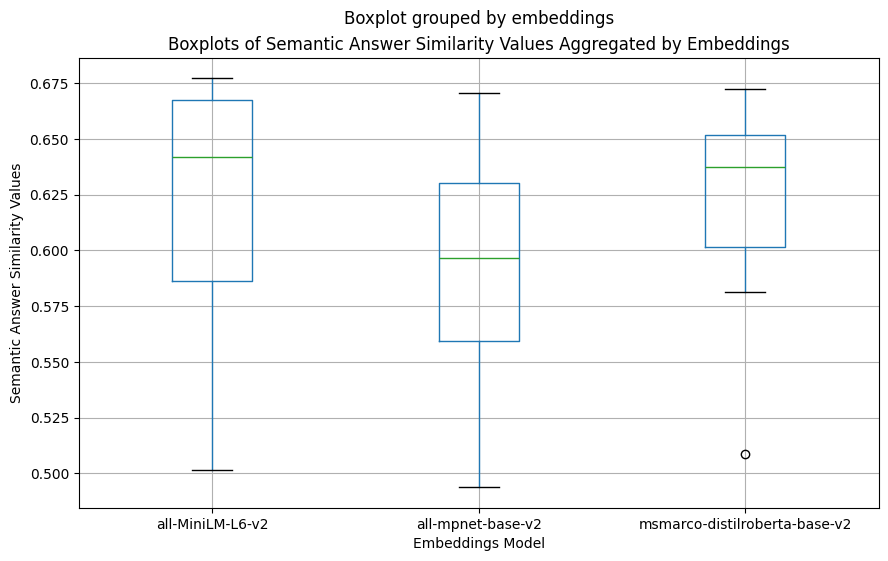

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
df.boxplot(column='sas', by='embeddings', ax=ax)

plt.xlabel("Embeddings Model")
plt.ylabel("Semantic Answer Similarity Values")
plt.title("Boxplots of Semantic Answer Similarity Values Aggregated by Embeddings")

plt.show()

### We can see that the `all-MiniLM-L6-V2` gives the best results overall. Which combination of parameters is the best for this particular embedding model?

In [ ]:
filtered_df = df[df['embeddings'] == 'all-MiniLM-L6-v2'].sort_values(by='sas', ascending=False)

In [ ]:
filtered_df

,context_relevance,faithfulness,sas,embeddings,top_k,chunk_size
11,NaN,0.948598,0.677247,all-MiniLM-L6-v2,3,128
26,NaN,0.938474,0.675843,all-MiniLM-L6-v2,3,256
24,0.949755,0.962617,0.667561,all-MiniLM-L6-v2,2,256
12,0.920249,0.928037,0.65659,all-MiniLM-L6-v2,2,128
4,0.927793,0.931464,0.641957,all-MiniLM-L6-v2,3,64
22,0.894407,0.884735,0.629849,all-MiniLM-L6-v2,2,64
23,0.893335,0.825234,0.586235,all-MiniLM-L6-v2,1,256
10,0.903645,0.831776,0.568433,all-MiniLM-L6-v2,1,128
21,0.870717,0.672897,0.501648,all-MiniLM-L6-v2,1,64


In [ ]:
detailed_best_sas_df = pd.read_csv("results/aragog_results/detailed_all-MiniLM-L6-v2__top_k:3__chunk_size:128.csv")

In [ ]:
detailed_best_sas_df

,Unnamed: 0,questions,true_answers,predicted_answers,context_relevance,faithfulness,sas
0,0,What are the two main tasks BERT is pre-traine...,Masked LM (MLM) and Next Sentence Prediction (...,BERT is pre-trained on the BooksCorpus (800M w...,0.833333,1.0,0.296899
1,1,"What model sizes are reported for BERT, and wh...","BERTBASE (L=12, H=768, A=12, Total Parameters=...","336M model, same size as BERT-Large with modif...",1.000000,1.0,0.517488
2,2,How does BERT's architecture facilitate the us...,BERT uses a multi-layer bidirectional Transfor...,BERT's architecture is designed to pretrain de...,1.000000,1.0,0.672141
3,3,Can you describe the modifications LLaMA makes...,LLaMA incorporates pre-normalization (using R...,The context does not provide any information a...,1.000000,0.0,0.447355
4,4,How does LLaMA's approach to embedding layer o...,LLaMA introduces optimizations in its embeddin...,LLaMA's approach to embedding layer optimizati...,0.750000,1.0,0.741207
...,...,...,...,...,...,...,...
102,102,How do the selected tasks in SuperGLUE reflect...,"The selected tasks, chosen for their difficult...",The selected tasks in SuperGLUE reflect the be...,1.000000,1.0,0.918031
103,103,"In the context of PAL, what role do meaningful...",Meaningful variable names in PAL's generated c...,"In the context of PAL, meaningful variable nam...",1.000000,1.0,0.794072
104,104,How does PAL address the execution of complex ...,PAL addresses complex computations by generat...,PAL addresses the execution of complex computa...,NaN,1.0,0.657133
105,105,How does SuperGLUE's design ensure it presents...,SuperGLUE introduces more challenging tasks re...,SuperGLUE's design ensures it presents a more ...,1.000000,1.0,0.764738


In [ ]:
def inspect(idx):
    print("Question: ")
    print(detailed_best_sas_df.loc[idx]['questions'])
    print("\nTrue Answer:")
    print(detailed_best_sas_df.loc[idx]['true_answers'])
    print()
    print("Generated Answer:")
    print(detailed_best_sas_df.loc[idx]['predicted_answers'])
    print()
    print(f"Context Relevance  : {detailed_best_sas_df.loc[idx]['context_relevance']}")
    print(f"Faithfulness       : {detailed_best_sas_df.loc[idx]['faithfulness']}")
    print(f"Semantic Similarity: {detailed_best_sas_df.loc[idx]['sas']}")

In [ ]:
inspect(9)

Question: 
What detailed methodology does LLaMA utilize to ensure the diversity of its pre-training data, particularly in the context of filtering and language identification?

True Answer:
LLaMA's methodology for ensuring data diversity includes comprehensive filtering criteria to remove low-quality content, language identification to support multilingual capabilities, and a balanced inclusion of various data sources such as Wikipedia, web text, and books, emphasizing the representation of a wide range of topics and languages.

Generated Answer:
nan

Context Relevance  : 0.0
Faithfulness       : 0.0
Semantic Similarity: -0.0054700877517461


---

In [ ]:
inspect(30)

Question: 
How does DistilBERT's performance on downstream tasks like IMDb sentiment classification and SQuAD v1.1 compare to BERT?

True Answer:
DistilBERT closely approaches BERT's performance on IMDb sentiment classification and SQuAD v1.1, with minimal performance loss despite its smaller size.

Generated Answer:
DistilBERT's performance on downstream tasks like IMDb sentiment classification and SQuAD v1.1 is slightly lower than BERT's performance, with DistilBERT being 0.6% point behind on the IMDb benchmark and within 3.9 points on SQuAD.

Context Relevance  : 1.0
Faithfulness       : 1.0
Semantic Similarity: 0.8965864181518555
